In [52]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

tf.random.set_seed(12) # we set our seed so that when we run the for loop to intialize an LSTM model, we have the same weights (taking away luck/variability)

### Cross Validating Our Best Model Results

In [14]:
train_data = pd.read_csv('train_scaled.csv')
test_data = pd.read_csv('test_scaled.csv')

train_dates = {}
test_dates = {}
all_dates = {}

for ticker in train_data["TickerName"].unique():

    train_dates[ticker] = train_data[train_data["TickerName"] == ticker]['date'][16:]
    test_dates[ticker] = test_data[test_data["TickerName"] == ticker]['date'][:len(test_data[test_data["TickerName"] == ticker]['date']) - 16]
    all_dates[ticker] = pd.concat([train_dates[ticker], test_dates[ticker]], ignore_index=True)

train_data.drop(["date", "open", "high", "low"], axis=1, inplace=True)
train_data.head()

test_data.drop(["date", "open", "high", "low"], axis=1, inplace=True)
test_data.head()

formatted_data = {}
all_formatted_data = {}

sequence_length = 15
for ticker in train_data["TickerName"].unique():
    formatted_data[ticker] = []
    all_formatted_data[ticker] = []

    temp_train_data = train_data[train_data["TickerName"] == ticker].drop(["TickerName"], axis=1)
    temp_train_data = temp_train_data.values
    X, y = [], []
    for i in range(len(temp_train_data) - sequence_length - 1):
        X.append(temp_train_data[i:i + sequence_length, :])
        y.append(temp_train_data[i + sequence_length + 1, 0])

    X, y = np.array(X), np.array(y)
    formatted_data[ticker].append([X, y])
    print(ticker, X.shape, y.shape)

    X, y = [], []
    temp_test_data = test_data[test_data["TickerName"] == ticker].drop(["TickerName"], axis=1).values
    for i in range(len(temp_test_data) - sequence_length - 1):
        X.append(temp_test_data[i:i + sequence_length, :])
        y.append(temp_test_data[i + sequence_length + 1, 0])
    X, y = np.array(X), np.array(y)
    formatted_data[ticker].append([X, y])
    print(ticker, X.shape, y.shape)
    
    all_formatted_data[ticker].append(np.concatenate([formatted_data[ticker][0][0], formatted_data[ticker][1][0]], axis = 0))
    all_formatted_data[ticker].append(np.concatenate([formatted_data[ticker][0][1], formatted_data[ticker][1][1]], axis = 0))
    print(ticker, all_formatted_data[ticker][0].shape, all_formatted_data[ticker][1].shape)
    
    print(ticker, "done")

KSCP (285, 15, 3) (285,)
KSCP (113, 15, 3) (113,)
KSCP (398, 15, 3) (398,)
KSCP done
GCT (187, 15, 3) (187,)
GCT (71, 15, 3) (71,)
GCT (258, 15, 3) (258,)
GCT done
ASST (105, 15, 3) (105,)
ASST (37, 15, 3) (37,)
ASST (142, 15, 3) (142,)
ASST done


In [15]:
def LSTM_model(nodes, num_layers):
    
    model = Sequential()

    model.add(LSTM(units=nodes, return_sequences=True, input_shape=(15, 3)))
    model.add(Dropout(0.2))
    
    for i in range(num_layers - 1):
        model.add(LSTM(units = 50, return_sequences=True))
        model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))
    
    model.compile(
    optimizer='adam', 
    loss='mean_squared_error')

    return model

### Referencing Our Grid Search Our Best Model Metrics Are...
- The best hyperparameters for KSCP's model are (50 epochs, 4 layers, 100 nodes, 20 batch size)
- The best hyperparamters for the other ticker models was (50 epochs, 5 layers, 100 nodes, 20 batch size)

In [ ]:
cv_results = {}

for ticker in train_data["TickerName"].unique():
    cv_results[ticker] = {}
    for i in range(1,11):    # only 10 because of computational constraints
        temp_data = formatted_data[ticker][0][0][:len(formatted_data[ticker][0][0]) - i]
        temp_labels = kscp2 = formatted_data[ticker][0][1][:len(formatted_data[ticker][0][1]) - i]
        
        if ticker == "KSCP":
            model = LSTM_model(100, 4)
        else:
            model = LSTM_model(100, 5)
        
        model.fit(temp_data, temp_labels, epochs = 50, batch_size = 20, verbose=0)
        
        cv_results[ticker][i] = model.evaluate(formatted_data[ticker][1][0], formatted_data[ticker][1][1], verbose=0)

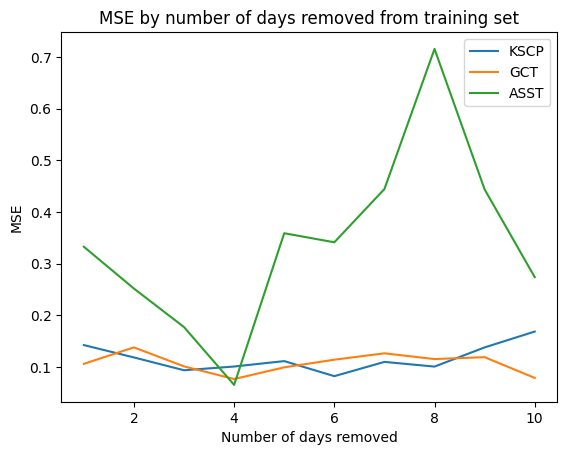

In [44]:
for ticker in train_data["TickerName"].unique():
    plt.plot(cv_results[ticker].keys(), cv_results[ticker].values(), label = ticker)
    plt.title("MSE by number of days removed from training set")
    plt.xlabel("Number of days removed")
    plt.ylabel("MSE")
    plt.legend()

In [ ]:
train_scaled = pd.read_csv("train_scaled.csv")
test_scaled = pd.read_csv("test_scaled.csv")

optimal_fit = {}

for i in ["KSCP", "GCT", "ASST"]:
    temporary = train_scaled[train_scaled["TickerName"] == i]
    model = pm.auto_arima(temporary["close"], start_p=1, start_q=1,
                           test='adf',
                           m=1,
                           d=None, 
                           seasonal=False,
                           start_P=0, 
                           D=0, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    optimal_fit[i] = model

### Calculating the MSE for ARMA models so we can compare

In [ ]:
acc_cv_results = {}
cv_results2 = {}
cv_aic = {}

for ticker in ["KSCP", "GCT", "ASST"]:
    temporary_data = train_scaled[train_scaled["TickerName"] == ticker]

    cv_results2[ticker] = []
    acc_cv_results[ticker] = []
    cv_aic[ticker] = []
    
    
    for i in range(17, 2, -1):
        if ticker == "ASST":
            if adfuller(temporary_data["close"][:len(temporary_data["close"]) - i])[1] <= 0.05:
                model = pm.auto_arima(temporary_data["close"][:len(temporary_data["close"]) - i], start_p=1, start_q=1,
                           test='adf',
                           m=1,
                           d=None, 
                           seasonal=False,
                           start_P=0, 
                           D=0, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           verbose = False)
                pred = model.predict(n_periods=2)
                cv_results2[ticker].append(pred)
                acc_cv_results[ticker].append(temporary_data[:len(temporary_data["close"]) - i + 2].iloc[-1])
                cv_aic[ticker].append(model.aic())
                


        elif ticker == "GCT":
            if adfuller(temporary_data["close"][:len(temporary_data["close"]) - i])[1] <= 0.05:
                model = pm.auto_arima(temporary_data["close"][:len(temporary_data["close"]) - i], start_p=1, start_q=1,
                           test='adf',
                           m=1,
                           d=None, 
                           seasonal=False,
                           start_P=0, 
                           D=0, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           verbose = False)
                pred = model.predict(n_periods=2)
                cv_results2[ticker].append(pred)
                acc_cv_results[ticker].append(temporary_data[:len(temporary_data["close"]) - i + 2].iloc[-1])
                cv_aic[ticker].append(model.aic())
               


        elif ticker == "KSCP":
            if adfuller(temporary_data["close"][:len(temporary_data["close"]) - i])[1] <= 0.05:
                model = pm.auto_arima(temporary_data["close"][:len(temporary_data["close"]) - i], start_p=1, start_q=1,
                           test='adf',
                           m=1,
                           d=None, 
                           seasonal=False,
                           start_P=0, 
                           D=0, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           verbose=False)
                pred = model.predict(n_periods=2)
                cv_results2[ticker].append(pred)
                acc_cv_results[ticker].append(temporary_data[:len(temporary_data["close"]) - i + 2].iloc[-1])
                cv_aic[ticker].append(model.aic())
                


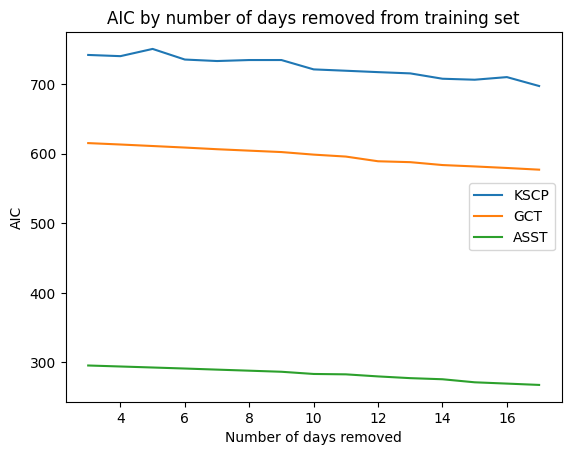

In [105]:
for ticker in ["KSCP", "GCT", "ASST"]:
    plt.plot(range(17, 2, -1), cv_aic[ticker], label = ticker)
    plt.title("AIC by number of days removed from training set")
    plt.xlabel("Number of days removed")
    plt.ylabel("AIC")
    plt.legend()

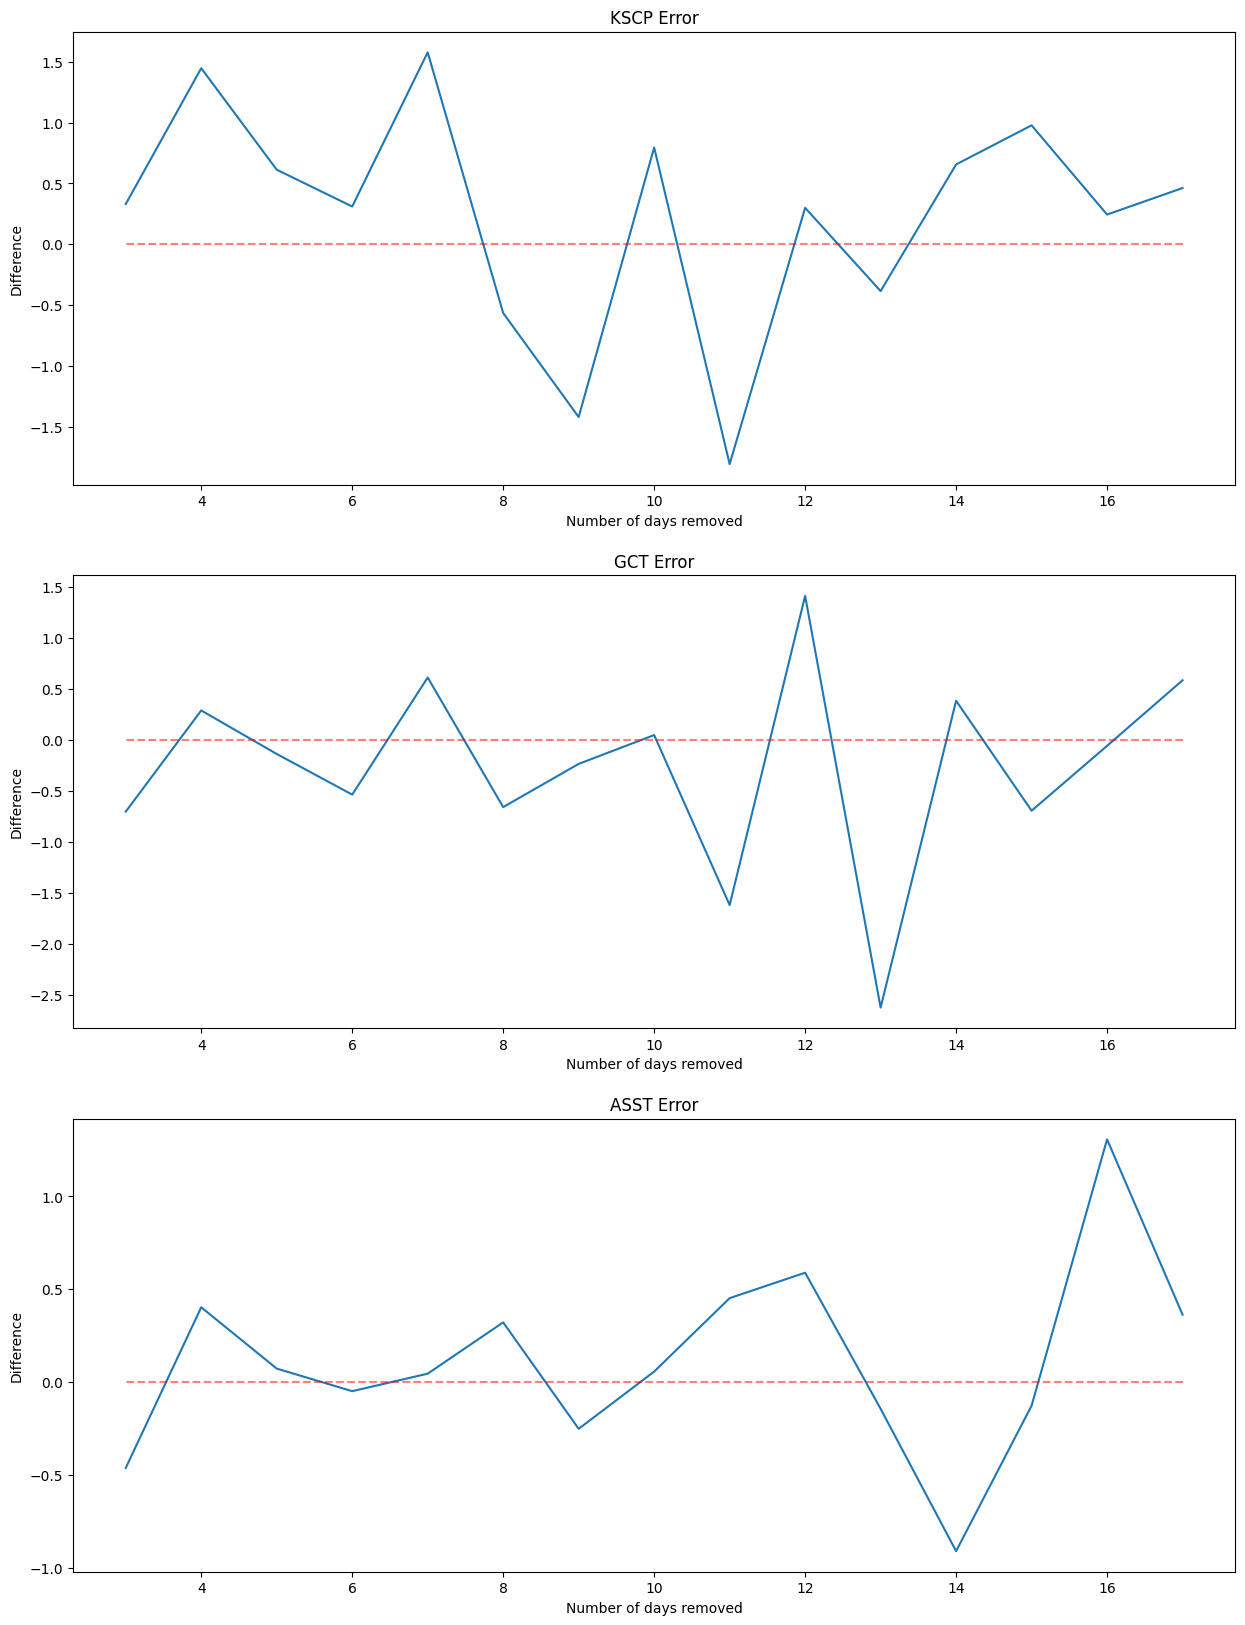

In [153]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))

for i, ticker in enumerate(["KSCP", "GCT", "ASST"]):
    axs[i].plot(range(17, 2, -1), np.array(acc_cv_results[ticker]) - np.array(cv_results2[ticker]))
    axs[i].plot(range(17, 2, -1), np.zeros(len(range(17, 2, -1))), color = "r", linestyle='--', alpha = 0.5)
    axs[i].set_title(f"{ticker} Error")
    axs[i].set_xlabel("Number of days removed")
    axs[i].set_ylabel("Difference")
